In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data_path = "../../data/image-data/output/one-class_syn2_size-color-diff-2D/images-config.tsv"
df = pd.read_csv(data_path, sep="\t", header=None)
df['features'] = df[4].map(lambda x:[float(i.split("=")[-1]) for i in x.split()])
df['f1'] = df['features'].map(lambda x:x[0])
df['f2'] = df['features'].map(lambda x:x[1])

In [17]:
x_w = df[['f1', 'f2']].loc[:99].values
x_v = df[['f1', 'f2']].loc[100:].values
x = np.vstack([x_w, x_v])

X_train_w = x_w[:80]
X_train_v = x_v[:80]
X_test_w = x_w[80:]
X_test_v = x_v[80:]

X_train = np.vstack([X_train_w, X_train_v])
X_test = np.vstack([X_test_w, X_test_v])
y_train = np.hstack([np.zeros(80), np.ones(80)]).astype(int)
y_test = np.hstack([np.zeros(20), np.ones(20)]).astype(int)

(0.0, 1.0)

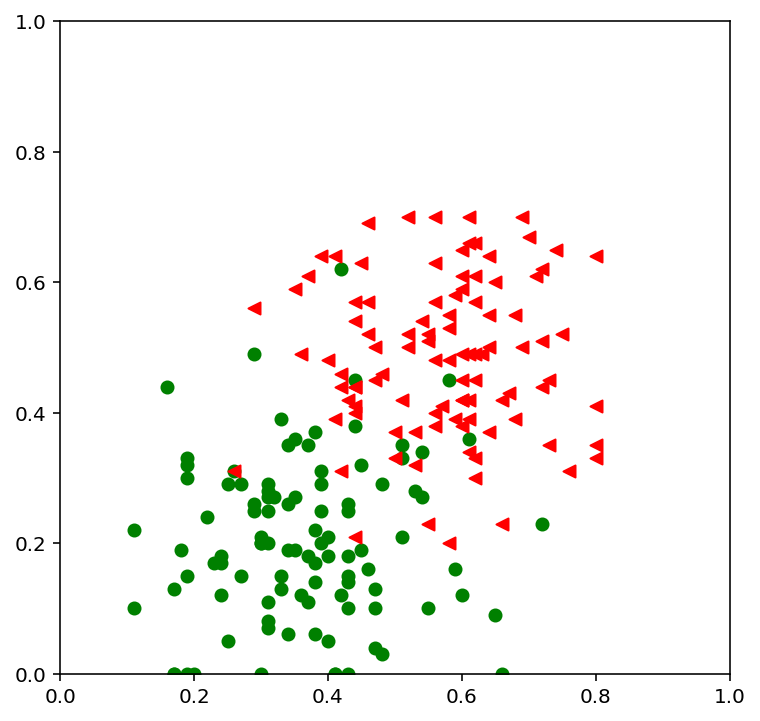

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_w[:,0], x_w[:,1], c='g', marker='o')
ax.scatter(x_v[:,0], x_v[:,1], c='r', marker='<')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [5]:
def param2hyp(orientation, intercept):
    w1, w2 = np.tan(orientation), -1
    b = intercept
    return np.array([w1, w2, b])

def add_bias(x):
    return np.hstack([x, np.ones([x.shape[0], 1])])

In [6]:
np.random.seed(42)
params = []
for i in range(8):
    means = [np.pi / 4 * i, 0]
    covs = [[2, 0], [0, .005]]
    for j in range(2):
        param = np.random.multivariate_normal(means, covs)
        params.append(param)
params = np.vstack(params)
simple_hyps = np.vstack(list(map(lambda x: param2hyp(*x), params)))

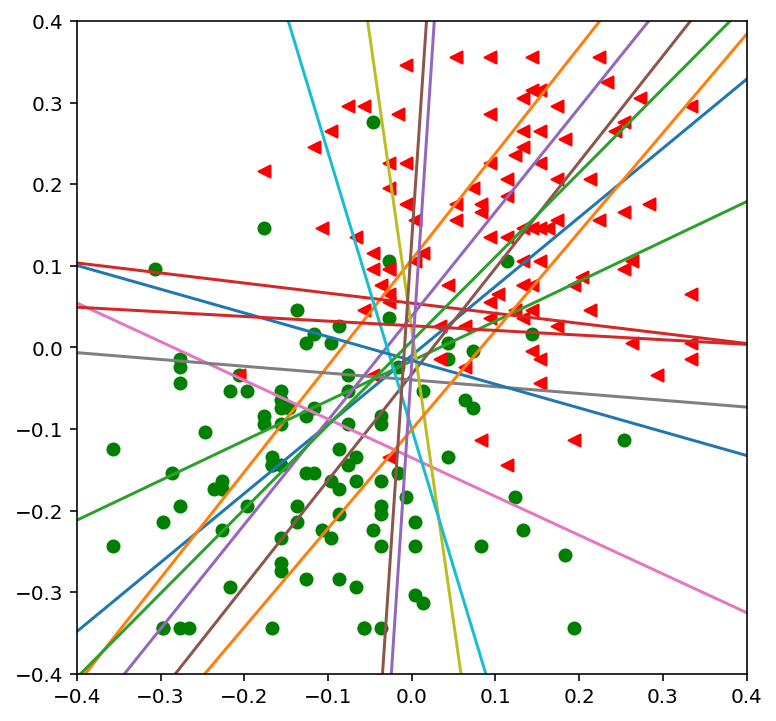

In [7]:
x_w_norm = x_w - x.mean(0)
x_v_norm = x_v - x.mean(0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_w_norm[:,0], x_w_norm[:,1], c='g', marker='o')
ax.scatter(x_v_norm[:,0], x_v_norm[:,1], c='r', marker='<')
ax.set_xlim([-.4, .4])
ax.set_ylim([-.4, .4])
x_lin = np.linspace(-.4, .4)
for i in range(len(params)):
    h = params[i]
    ax.plot(x_lin, x_lin * np.tan(h[0]) + h[1])
# h = simple_hyps[0]
# pos_w = np.where(add_bias(x_w_norm) @ h > 0)
# pos_v = np.where(add_bias(x_v_norm) @ h > 0)
# ax.scatter(x_w_norm[pos_w,0], x_w_norm[pos_w,1], c='y', marker='+')
# ax.scatter(x_v_norm[pos_v,0], x_v_norm[pos_v,1], c='y', marker='+')
# ax.plot(x_lin, x_lin * np.tan(h[0]) + h[1])
# ax.grid()

## teaching

In [8]:
from sklearn.decomposition import PCA
import offline_teachers as teach
import datasets as ds
import utils as ut
import data_output as op
import hypothesis as hp

import warnings
warnings.filterwarnings("ignore")

In [9]:
num_teaching_itrs = 20
num_init_hyps = 16
density_sigma = 1.0
alpha = 2
hyp_type = 'k_octa'

add_bias = True
remove_mean = True
do_pca = False
pca_dims = 2

def preprocess(X, remove_mean, do_pca, add_bias):
    # standardize
    if remove_mean:
        X = X - X.mean(0)
        X = X / X.std(0)
    # add 1 for bias (intercept) term
    if add_bias:
        X = np.hstack((X, np.ones(X.shape[0])[..., np.newaxis]))
    return X

In [18]:
datasets = {}

dataset = {}
dataset['X'] = X_train
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = y_train
dataset['im_files'] = np.ones(y_train.shape[0])
dataset['explain_files'] = np.asarray([''] * y_train.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(y_train).shape[0])
dataset['explain_interp'] = np.ones(y_train.shape[0])
datasets['train'] = dataset

dataset = {}
dataset['X'] = X_test
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = y_test
dataset['im_files'] = np.ones(y_test.shape[0])
dataset['explain_files'] = np.asarray([''] * y_test.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(y_test).shape[0])
dataset['explain_interp'] = np.ones(y_test.shape[0])
datasets['test'] = dataset

In [20]:
import random
random.seed(42)
np.random.seed(42)

# load data
dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
if len(np.unique(dataset_train['Y'])) > 2:
    one_v_all = True  # multi class
else:
    one_v_all = False # binary

 # density of points
# dataset_train['X_density'] = ut.compute_density(dataset_train['X'], dataset_train['Y'], density_sigma, True)

# generate set of hypotheses
# hyps, prior_h = hp.generate_hyps(dataset_train, alpha, num_init_hyps, hyp_type, one_v_all)
hyps = np.array([z for z in zip(simple_hyps, -simple_hyps)])
prior_h = np.ones(len(hyps)) / float(len(hyps))
print(len(hyps), hyp_type, 'hypotheses\n')

# remove examples that are inconsistent with best hypothesis
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

# re compute hypothesis errors - after removing inconsistent examples
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error_one_vs_all(hyps, dataset_test['X'], dataset_test['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], alpha)

# compute the likelihood for each datapoint according to each hypothesis
if one_v_all:
    likelihood  = ut.compute_likelihood_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    likelihood = ut.compute_likelihood(hyps, dataset_train['X'], dataset_train['Y'], alpha)

# teachers
teachers = {}
if one_v_all:
    teachers['rand_1vall'] = teach.RandomImageTeacherOneVsAll(dataset_train, alpha, prior_h)
    teachers['strict_1vall'] = teach.StrictTeacherOneVsAll(dataset_train, alpha, prior_h)
    # teachers['explain_1vall'] = teach.ExplainTeacherOneVsAll(dataset_train, alpha, prior_h)
else:
    teachers['random'] = teach.EfficientRandomImageTeacher(dataset_train, alpha, prior_h, hyps)
    teachers['strict'] = teach.EfficientStrictTeacher(dataset_train, alpha, prior_h, hyps)
    # teachers['explain'] = teach.ExplainTeacher(dataset_train, alpha, prior_h)

# run teaching
for alg_name in teachers.keys():
    print(alg_name)
    teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, likelihood, hyps, err_hyp, err_hyp_test)

16 k_octa hypotheses

15 train examples removed
0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159

 train [0 1] [70 75]
0                                	 70
1                                	 75
random
strict
0 	 1 	 125 	 -0.0156
1 	 0 	 20 	 -0.0014
2 	 0 	 56 	 -0.0005
3 	 1 	 120 	 -0.0002
4 	 0 	 7 	 -0.0002
5 	 1 	 85 	 -0.0001
6 	 1 	 79 	 -0.0001
7 	 0 	 67 	 -0.0001
8 	 1 	 98 	 -0.0001
9 	 1 	 110 	 -0.0001
1

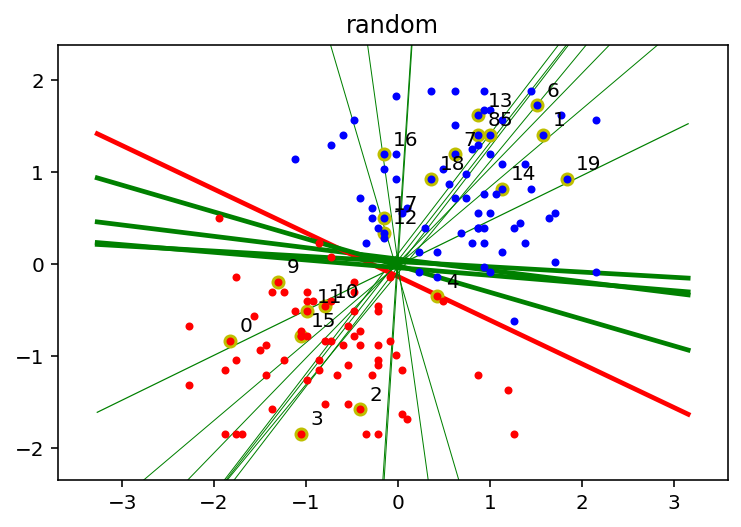

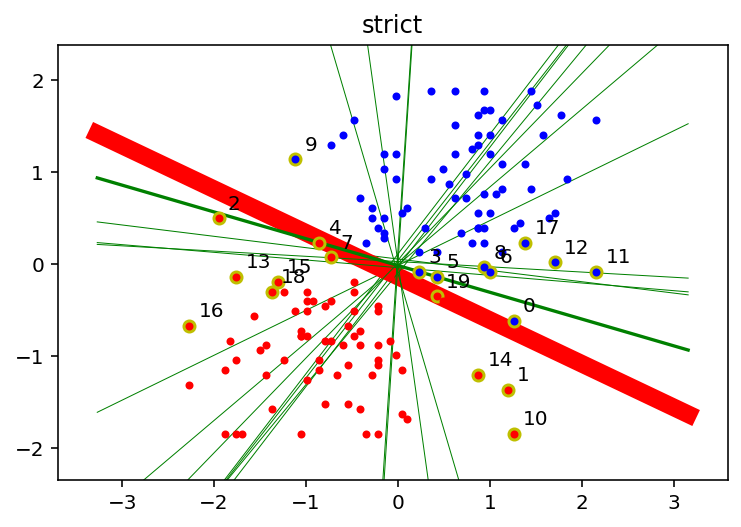

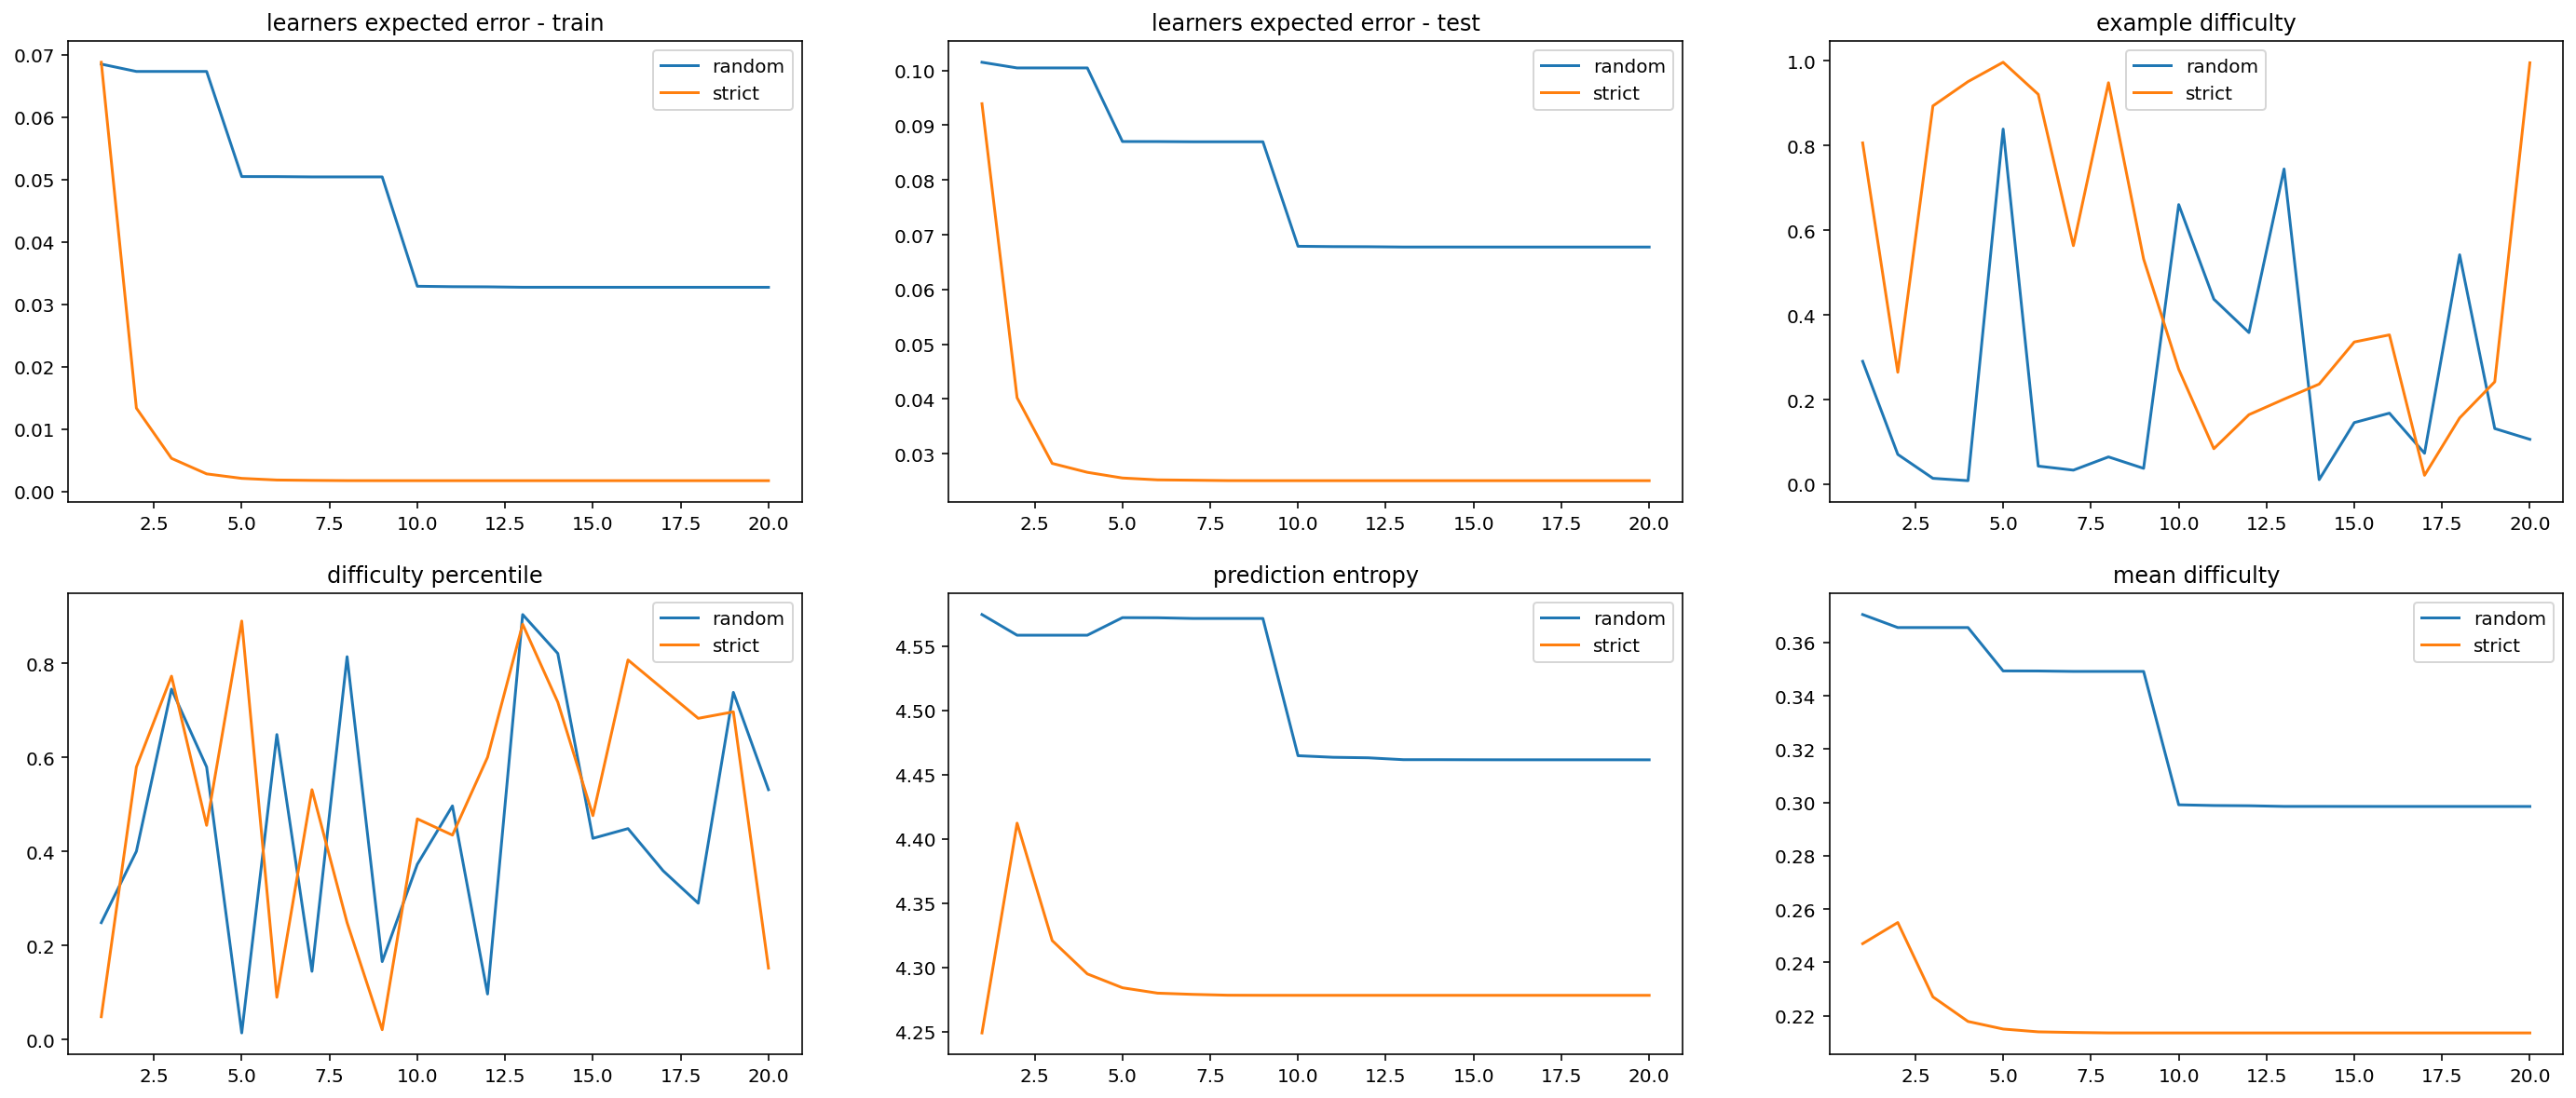

In [21]:
# plot in 2D
fig_id = 0
if (dataset_train['X'].shape[1] <= 3):
    for alg_name in teachers.keys():
        if one_v_all:
            ut.plot_2D_data(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        else:
            ut.plot_2D_data_hyper(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        fig_id += 1

fig, ax = plt.subplots(2, 3, figsize=(24, 10))

ax[0, 0].set_title('learners expected error - train')
for alg_name in teachers.keys():
    exp_err = teachers[alg_name].stats['exp_err']
    ax[0, 0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0, 0].legend()

ax[0, 1].set_title('learners expected error - test')
for alg_name in teachers.keys():
    exp_err_test = teachers[alg_name].stats['exp_err_test']
    ax[0, 1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[0, 1].legend()

ax[0, 2].set_title('example difficulty')
for alg_name in teachers.keys():
    difficulty = teachers[alg_name].stats['difficulty']
    ax[0, 2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[0, 2].legend()
fig.show()

ax[1, 0].set_title('difficulty percentile')
for alg_name in teachers.keys():
    diff_pctl = teachers[alg_name].stats['diff_pctl']
    ax[1, 0].plot(np.arange(len(diff_pctl))+1, diff_pctl, label=alg_name)
ax[1, 0].legend()
fig.show()

ax[1, 1].set_title('prediction entropy')
for alg_name in teachers.keys():
    pred_ent = teachers[alg_name].stats['pred_ent']
    ax[1, 1].plot(np.arange(len(pred_ent))+1, pred_ent, label=alg_name)
ax[1, 1].legend()
fig.show()

ax[1, 2].set_title('mean difficulty')
for alg_name in teachers.keys():
    diff_mean = teachers[alg_name].stats['diff_mean']
    ax[1, 2].plot(np.arange(len(diff_mean))+1, diff_mean, label=alg_name)
ax[1, 2].legend()
fig.show()